<a href="https://colab.research.google.com/github/osherlock1/AI-Image-Detection-Model/blob/main/main_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##**Start with a Resnet Model, Try ViTs if we have time**

## **Imports**

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
import matplotlib.pyplot as plt

from google.colab import drive

## **Import Dataset**

In [2]:
# prompt: connect to google drive

drive.mount('/content/drive')


Mounted at /content/drive


In [3]:
data_dir = "/content/drive/MyDrive/URI_spr25/ELE392/AI_Detection_Model/Datasets/Processed_Dataset"  # Update if needed


In [4]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

dataset = datasets.ImageFolder(root=data_dir, transform=transform)

**Create DataLoaders**

In [5]:
#Split Datset

train_len = int(len(dataset) * 0.8)
val_len = int(len(dataset) * 0.1)
test_len = len(dataset) - train_len - val_len # test_len will automatically be an int

train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_len, val_len, test_len])

In [6]:
#Create DataLoaders
batch_size = 32

train_loader = DataLoader(train_dataset, batch_size = batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size = batch_size, shuffle=True);
test_loader = DataLoader(test_dataset, batch_size = batch_size, shuffle = False)

## **Train with Resnet Model**

In [10]:
#Define Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#Use Resnset18 for now
model = models.resnet18(pretrained=True)
model.fc = nn.Linear(model.fc.in_features, 1)  # Binary classification
model = model.to(device)


In [11]:
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

**Training Loop**

In [9]:
num_epochs = 10

for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    train_correct = 0
    train_total = 0

    for data, labels in train_loader:
        data = data.to(device)
        labels = labels.float().unsqueeze(1).to(device)

        optimizer.zero_grad()
        pred = model(data)
        loss = criterion(pred, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

        # Accuracy
        preds = torch.sigmoid(pred)
        predicted_labels = (preds > 0.5).float()
        train_correct += (predicted_labels == labels).sum().item()
        train_total += labels.size(0)

    avg_train_loss = train_loss / len(train_loader)
    train_accuracy = train_correct / train_total

    # Evaluation
    model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0

    with torch.no_grad():
        for data, labels in val_loader:
            data = data.to(device)
            labels = labels.float().unsqueeze(1).to(device)

            pred = model(data)
            loss = criterion(pred, labels)
            val_loss += loss.item()

            preds = torch.sigmoid(pred)
            predicted_labels = (preds > 0.5).float()
            val_correct += (predicted_labels == labels).sum().item()
            val_total += labels.size(0)

    avg_val_loss = val_loss / len(val_loader)
    val_accuracy = val_correct / val_total

    print(f"Epoch {epoch+1}/{num_epochs} | "
          f"Train Loss: {avg_train_loss:.4f} | Train Acc: {train_accuracy:.2%} | "
          f"Val Loss: {avg_val_loss:.4f} | Val Acc: {val_accuracy:.2%}")


KeyboardInterrupt: 

In [12]:
max_batches_per_epoch = 10  # train on only 10 batches per epoch

for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    train_correct = 0
    train_total = 0

    for batch_idx, (data, labels) in enumerate(train_loader):
        if batch_idx >= max_batches_per_epoch:
            break

        data = data.to(device)
        labels = labels.float().unsqueeze(1).to(device)

        optimizer.zero_grad()
        pred = model(data)
        loss = criterion(pred, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        preds = torch.sigmoid(pred)
        predicted_labels = (preds > 0.5).float()
        train_correct += (predicted_labels == labels).sum().item()
        train_total += labels.size(0)

    avg_train_loss = train_loss / max_batches_per_epoch
    train_accuracy = train_correct / train_total

    # ---------- Evaluation (unchanged) ----------
    model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0

    with torch.no_grad():
        for data, labels in val_loader:
            data = data.to(device)
            labels = labels.float().unsqueeze(1).to(device)

            pred = model(data)
            loss = criterion(pred, labels)
            val_loss += loss.item()

            preds = torch.sigmoid(pred)
            predicted_labels = (preds > 0.5).float()
            val_correct += (predicted_labels == labels).sum().item()
            val_total += labels.size(0)

    avg_val_loss = val_loss / len(val_loader)
    val_accuracy = val_correct / val_total

    print(f"Epoch {epoch+1}/{num_epochs} | "
          f"Train Loss: {avg_train_loss:.4f} | Train Acc: {train_accuracy:.2%} | "
          f"Val Loss: {avg_val_loss:.4f} | Val Acc: {val_accuracy:.2%}")


Epoch 1/10 | Train Loss: 0.3127 | Train Acc: 89.38% | Val Loss: 0.2209 | Val Acc: 91.46%
Epoch 2/10 | Train Loss: 0.1319 | Train Acc: 95.31% | Val Loss: 0.0510 | Val Acc: 97.97%
Epoch 3/10 | Train Loss: 0.0415 | Train Acc: 99.06% | Val Loss: 0.0295 | Val Acc: 99.19%
Epoch 4/10 | Train Loss: 0.0206 | Train Acc: 100.00% | Val Loss: 0.0273 | Val Acc: 99.19%
Epoch 5/10 | Train Loss: 0.0193 | Train Acc: 99.38% | Val Loss: 0.0140 | Val Acc: 100.00%
Epoch 6/10 | Train Loss: 0.0228 | Train Acc: 99.38% | Val Loss: 0.0143 | Val Acc: 99.59%
Epoch 7/10 | Train Loss: 0.0153 | Train Acc: 99.38% | Val Loss: 0.0242 | Val Acc: 98.78%
Epoch 8/10 | Train Loss: 0.0168 | Train Acc: 100.00% | Val Loss: 0.0144 | Val Acc: 99.59%
Epoch 9/10 | Train Loss: 0.0070 | Train Acc: 100.00% | Val Loss: 0.0147 | Val Acc: 99.19%
Epoch 10/10 | Train Loss: 0.0075 | Train Acc: 100.00% | Val Loss: 0.0207 | Val Acc: 99.19%


In [13]:
def test_model(model, test_loader, criterion):
    model.eval()
    test_loss = 0.0
    correct = 0
    total = 0

    all_preds = []
    all_labels = []

    with torch.no_grad():
        for data, labels in test_loader:
            data = data.to(device)
            labels = labels.float().unsqueeze(1).to(device)

            outputs = model(data)
            loss = criterion(outputs, labels)
            test_loss += loss.item()

            preds = torch.sigmoid(outputs)
            predicted_labels = (preds > 0.5).float()

            correct += (predicted_labels == labels).sum().item()
            total += labels.size(0)

            all_preds.extend(predicted_labels.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    avg_test_loss = test_loss / len(test_loader)
    accuracy = correct / total

    print(f"✅ Test Loss: {avg_test_loss:.4f} | Test Accuracy: {accuracy:.2%}")

    return all_preds, all_labels


In [15]:
predictions, true_labels = test_model(model, test_loader, criterion)

✅ Test Loss: 0.0158 | Test Accuracy: 99.59%


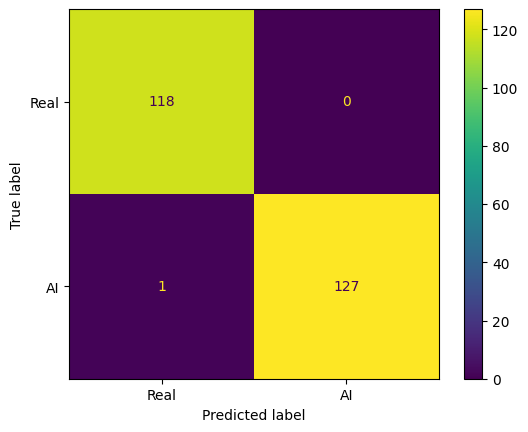

In [16]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(true_labels, predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Real", "AI"])
disp.plot()
